In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")
from read_tfrecords import OccnetTfrecordLoader
from models.research.keypointnet.main import Transformer
from models.research.keypointnet.main import *

In [79]:
import cv2

In [2]:
sess = tf.Session()

In [3]:
occnet_dataloader = OccnetTfrecordLoader("../datasets/00004/", occnet_data=True)
occnet_transformer = Transformer(128, 128, "../datasets/00004/", occnet=True)
features = occnet_dataloader.get_features()
# features = sess.run(features)

In [4]:
keypointnet_dataloader = OccnetTfrecordLoader("../../data/cars_with_keypoints/", occnet_data=False)
keypointnet_transformer = Transformer(128, 128, "../../data/cars_with_keypoints/", occnet=False)
keypointnet_features = keypointnet_dataloader.get_features()
# keypointnet_features = sess.run(keypointnet_features)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [171]:
def func1(x):
    return tf.transpose(tf.reshape(keypointnet_features[x], [-1, 4, 4]), [0, 2, 1])

mv = [func1("mv%d" % i) for i in range(2)]
mvi = [func1("mvi%d" % i) for i in range(2)]

In [190]:
u, v = 0.0, 0.0
points = []
for z in np.linspace(-50.0, 0.0, num=200):
    points.append([u, v, z])
    
uvz = tf.constant([points])

In [191]:
world_coords = tf.matmul(keypointnet_transformer.unproject(uvz), mvi[0])
uvz_proj = keypointnet_transformer.project(tf.matmul(world_coords, mv[1 - 0]))


In [192]:
uvz, uvz_proj, img0, img1 = sess.run(
    [
        uvz,
        uvz_proj,
        keypointnet_features["img0"][0, :, :, :3],
        keypointnet_features["img1"][0, :, :, :3]
    ]
)

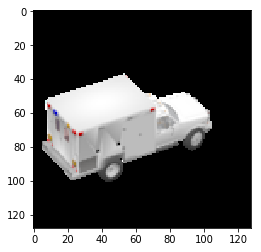

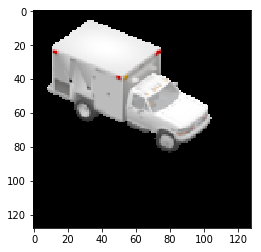

In [193]:
plt.imshow(img0)
plt.show()
plt.imshow(img1)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


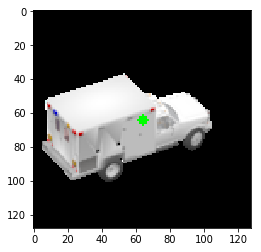

In [194]:
# draw on the image
x = int((u + 1.0) * 64.0)
y = int((v + 1.0) * 64.0)
new_img0 = cv2.circle(img0.copy(), (x, y), 3, (0, 255, 0), -1)
plt.imshow(new_img0)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


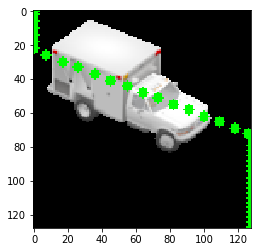

In [195]:
new_img1 = img1.copy()
for index, point in enumerate(uvz_proj[0]):
#     print(index)
#     print(point)
    u, v, z = point
    x = (min(max(u, -1), 1) * vw / 2 + vw / 2) - 0.5
    y = vh - 0.5 - (min(max(v, -1), 1) * vh / 2 + vh / 2)
    x = int(round(x))
    y = int(round(y))
    
#     print(x,y)
    
    new_img1 = cv2.circle(new_img1, (x, y), 3, (0, 255, 0), -1)

plt.imshow(new_img1)
plt.show()